In [1]:
!pip install tensorflow keras sentence-transformers

  Using cached tensorflow-2.18.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached sentence_transformers-3.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached grpcio-1.68.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached h5py-3.12.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx

In [2]:
!pip install keras-tuner --upgrade

  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached h5py-3.12.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached h5py-3.12.1-cp311-cp311-macosx_11_0_arm64.whl (2.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.8/736.8 kB 3.6 MB/s eta 0:00:00-:--:--


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kerastuner.tuners import Hyperband
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch



/var/folders/m9/4j5hjgcd5qngvl020z555w240000gn/T/ipykernel_63566/3529243669.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [73]:
df = pd.read_csv('Dataset_with_new_features.csv')


In [74]:
# Check for the total number of NaNs in each column
nan_summary = df.isna().sum()
print("\nCount of NaN values per column:")
print(nan_summary[nan_summary > 0]) 


Count of NaN values per column:
source        912
temp            1
perplexity      1
dtype: int64


In [75]:
df = df[~df['perplexity'].isna()]


In [76]:
#Dropping rows that have invalid values for the target variable
rows_to_drop = df[df['generated'] == 'generated'].index

dataset = df.drop(rows_to_drop)

In [77]:
dataset.shape
print(dataset.columns.tolist())


['essay_id', 'text', 'source', 'generated', 'temp', 'word_count', 'average_word_length', 'vocabulary_richness', 'flesch_kincaid', 'gunning_fog', 'smog_index', 'polarity', 'subjectivity', 'misspelled_word_count', 'sentence_length', 'punctuation_count', 'punctuation_density', 'pos_counts', 'pos_density', 'noun_count', 'verb_count', 'adjective_count', 'adverb_count', 'noun_density', 'verb_density', 'adjective_density', 'adverb_density', 'perplexity', 'ai_ratio']


In [78]:
print("Is GPU available?", torch.cuda.is_available())

Is GPU available? False


In [79]:
# To Check for Cosine Similarity texts and remove the texts that are more than 90% similar

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


texts = dataset["text"].tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

cosine_sim_matrix = cosine_similarity(tfidf_matrix)

to_remove = set()
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        if cosine_sim_matrix[i, j] > 0.9:
            to_remove.add(j)

print(len(to_remove))
df_distinct = dataset.drop(list(to_remove)).reset_index(drop=True)
df_distinct = dataset.drop(list(to_remove)).reset_index(drop=True)
print(df_distinct.shape)

184
(9426, 29)


In [80]:
features = df_distinct.drop(columns=['essay_id', 'text', 'source', 'generated', 'temp', 'word_count', 'average_word_length', 'flesch_kincaid', 'misspelled_word_count', 'sentence_length', 'punctuation_count', 'punctuation_density', 'pos_counts', 'pos_density', 'noun_count', 'verb_count', 'adjective_count', 'adverb_count', 'ai_ratio'])


In [81]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vocabulary_richness  9426 non-null   float64
 1   gunning_fog          9426 non-null   float64
 2   smog_index           9426 non-null   float64
 3   polarity             9426 non-null   float64
 4   subjectivity         9426 non-null   float64
 5   noun_density         9426 non-null   float64
 6   verb_density         9426 non-null   float64
 7   adjective_density    9426 non-null   float64
 8   adverb_density       9426 non-null   float64
 9   perplexity           9426 non-null   float64
dtypes: float64(10)
memory usage: 736.5 KB


In [82]:
X = features
y = df_distinct['generated']
y.astype(int)  # Target column
X = np.array(X, dtype=np.float32)  # Convert X to float32
y = np.array(y, dtype=np.float32)

In [83]:
# Creating train, validation and test datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 5655
Validation set size: 1885
Test set size: 1886


In [84]:
# Using Standard scaler to scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [113]:
X_train.shape

(5655, 10)

In [91]:
# Multi layer perceptron model
def build_model(hp):
    model = Sequential([
        Input(shape=(X.shape[1],)),  # Input shape based on combined feature vector
        Dense(hp.Int('units_1', 16, 64, step=32), activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(hp.Float('dropout_1', 0.2, 0.6, step=0.1)),
        Dense(hp.Int('units_2', 8, 32, step=16), activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(hp.Float('dropout_2', 0.2, 0.6, step=0.1)),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-5, 1e-6])),
        loss='binary_crossentropy',
        metrics=['accuracy',Precision(), Recall(), AUC()]
    )
    return model


In [92]:
# Hyperband tuner for hyperparameter tuning

import os
import shutil
if os.path.exists('mlp_tuning'):
    shutil.rmtree('mlp_tuning')
    
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=2,
    directory='mlp_tuning',
    project_name='mlp_tune_embeddings'
)

In [93]:
# Tuning the model with the training and validation data to find the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)


Trial 21 Complete [00h 00m 04s]
val_accuracy: 0.6387267708778381

Best val_accuracy So Far: 0.8450928330421448
Total elapsed time: 00h 01m 07s


In [94]:
# Getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'units_1': 48, 'dropout_1': 0.2, 'units_2': 24, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0006'}


In [95]:
# Training the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4956 - auc_3: 0.4666 - loss: 0.7290 - precision_3: 0.3923 - recall_3: 0.4290 - val_accuracy: 0.7135 - val_auc_3: 0.7519 - val_loss: 0.6419 - val_precision_3: 0.7122 - val_recall_3: 0.5426
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6615 - auc_3: 0.6900 - loss: 0.6391 - precision_3: 0.5996 - recall_3: 0.5368 - val_accuracy: 0.8090 - val_auc_3: 0.8576 - val_loss: 0.5693 - val_precision_3: 0.8487 - val_recall_3: 0.6679
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - auc_3: 0.8135 - loss: 0.5659 - precision_3: 0.7384 - recall_3: 0.6332 - val_accuracy: 0.8297 - val_auc_3: 0.8792 - val_loss: 0.5084 - val_precision_3: 0.8664 - val_recall_3: 0.7068
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - auc_3: 0.8580 - loss: 0.5124 - precision_3: 0.8009 - recall_3: 0.6762 - val_accuracy: 0.8366 - val_auc_3: 0.8939 - val_loss: 0.4589 - val_precision_3: 0.8668 - val_r

In [96]:
# Evaluating the model on the test data
loss, accuracy,precision, recall, auc  = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9204 - auc_3: 0.9658 - loss: 0.2337 - precision_3: 0.9352 - recall_3: 0.8753 
Test Loss: 0.21839305758476257
Test Accuracy: 0.9278897047042847
Test Precision: 0.9354413747787476
Test Recall: 0.8908406496047974
Test AUC: 0.972092866897583


In [97]:
# Read the data from the huggingface dataset
df_htest = pd.read_csv('huggingface_with_perplexity.csv')

In [98]:
rows_to_drop = df_htest[df_htest['generated'] == 'generated'].index
df_htest_mod = df_htest.drop(rows_to_drop)

In [99]:
df_htest_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 15000 non-null  object 
 1   generated            15000 non-null  int64  
 2   word_count           15000 non-null  int64  
 3   vocabulary_richness  15000 non-null  float64
 4   gunning_fog          15000 non-null  float64
 5   smog_index           15000 non-null  float64
 6   polarity             15000 non-null  float64
 7   subjectivity         15000 non-null  float64
 8   noun_count           15000 non-null  int64  
 9   verb_count           15000 non-null  int64  
 10  adverb_count         15000 non-null  int64  
 11  noun_density         15000 non-null  float64
 12  verb_density         15000 non-null  float64
 13  adjective_density    15000 non-null  float64
 14  adverb_density       15000 non-null  float64
 15  perplexity           15000 non-null 

In [114]:
features_test_h = df_htest_mod.drop(columns=[ 'text', 'generated', 'word_count', 'noun_count', 'verb_count', 'adverb_count'])


In [115]:
features_test_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vocabulary_richness  15000 non-null  float64
 1   gunning_fog          15000 non-null  float64
 2   smog_index           15000 non-null  float64
 3   polarity             15000 non-null  float64
 4   subjectivity         15000 non-null  float64
 5   noun_density         15000 non-null  float64
 6   verb_density         15000 non-null  float64
 7   adjective_density    15000 non-null  float64
 8   adverb_density       15000 non-null  float64
 9   perplexity           15000 non-null  float64
dtypes: float64(10)
memory usage: 1.1 MB


In [116]:
X_test_h = features_test_h
y_test_h = df_htest_mod['generated']
y.astype(int)  # Target column
X_test_h = np.array(X_test_h, dtype=np.float32)  # Convert X to float32
y_test_h = np.array(y_test_h, dtype=np.float32)

In [117]:
# Scaling the test input data
scaler = StandardScaler()
X_test_h = scaler.fit_transform(X_test_h)

In [118]:
X_test_h.shape[1]

10

In [112]:
best_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 48)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,189 (20.27 KB)

 Trainable params: 1,729 (6.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,460 (13.52 KB)

In [121]:
# Predicting on the huggingface test data
y_pred = (best_model.predict(X_test_h) > 0.5).astype(int)  # Predicted labels
y_prob = best_model.predict(X_test_h).ravel()  # Predicted probabilities

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


In [125]:
# Classification report and confusion matrix for the test data
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test_h, y_prob)
roc_auc = auc(fpr, tpr)
balanced_accuracy = 0.5 * (tpr.mean() + (1 - fpr).mean())

In [130]:
print(f"ROC AUC: {roc_auc}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"True Positive Rate: {tpr.mean()}")
print(f"False Positive Rate: {fpr.mean()}")
print(f"Thresholds: {thresholds}")

ROC AUC: 0.9921745422222221
Balanced Accuracy: 0.8402316956412195
True Positive Rate: 0.9024413202317966
False Positive Rate: 0.22197792894935753
Thresholds: [          inf 9.9981755e-01 9.9960160e-01 ... 5.8463135e-16 1.7398665e-18
 1.7625696e-37]


In [126]:
print(balanced_accuracy)

0.8402316956412195


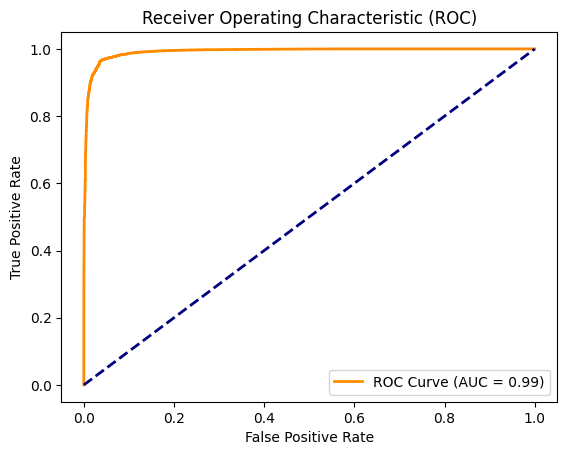

In [129]:
# Plotting the ROC curve
from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

In [119]:
# Evaluating model using accuracy, precision, recall, auc for the test data
loss, accuracy, precision, recall, auc = best_model.evaluate(X_test_h, y_test_h)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9629 - auc_3: 0.9924 - loss: 0.1263 - precision_3: 0.9586 - recall_3: 0.9674
Test Loss: 0.1274024397134781
Test Accuracy: 0.9634666442871094
Test Precision: 0.9607635140419006
Test Recall: 0.9664000272750854
Test AUC: 0.9921613931655884


In [132]:

feature_names = features.columns.tolist()
print(feature_names)
X_train_df = pd.DataFrame(X_train, columns=features.columns)

['vocabulary_richness', 'gunning_fog', 'smog_index', 'polarity', 'subjectivity', 'noun_density', 'verb_density', 'adjective_density', 'adverb_density', 'perplexity']


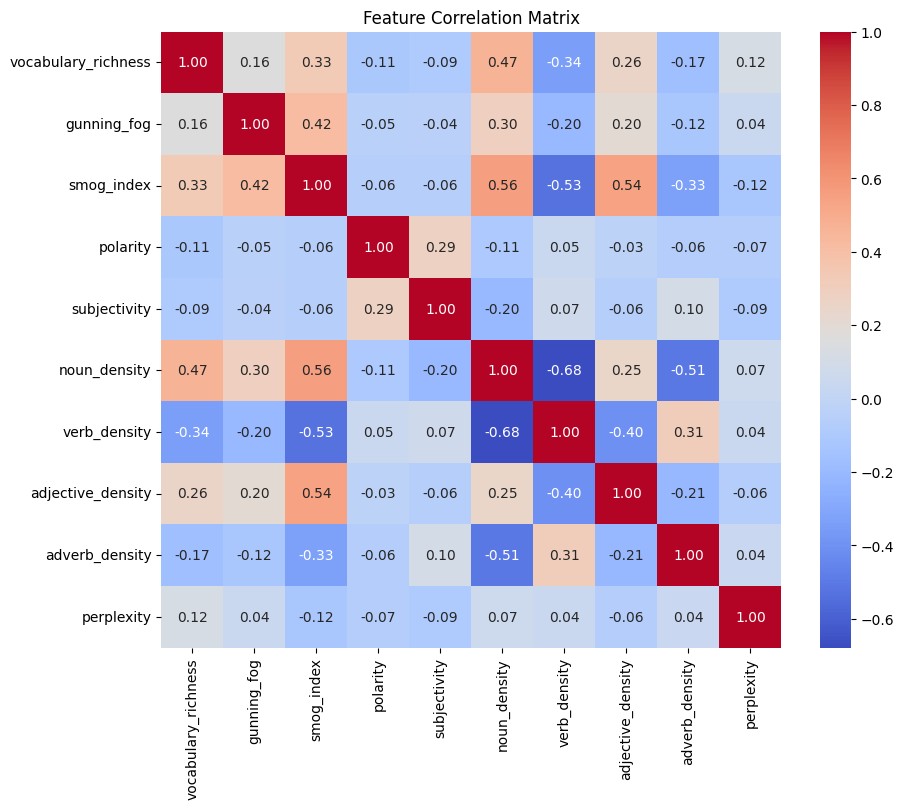

In [134]:
# Plotting the feature correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train is a pandas DataFrame
correlation_matrix = X_train_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

ExactExplainer explainer: 5656it [02:53, 30.45it/s]                          


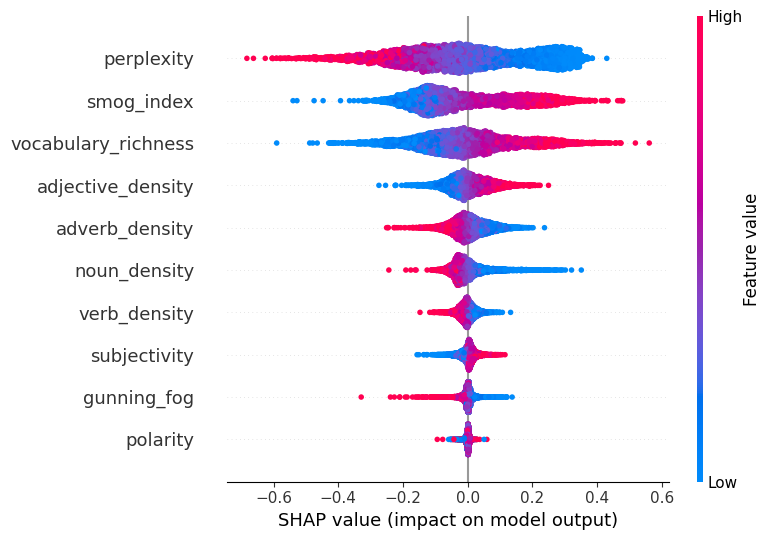

In [135]:
# Plotting the feature importance using SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# Plot summary
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

In [72]:
features.info()

NameError: name 'features' is not defined

In [137]:
features_new = df_distinct.drop(columns=['essay_id', 'text', 'source', 'generated', 'temp', 'word_count', 'average_word_length', 'flesch_kincaid', 'misspelled_word_count', 'sentence_length', 'punctuation_count', 'punctuation_density', 'pos_counts', 'pos_density', 'noun_count', 'verb_count', 'adjective_count', 'adverb_count', 'ai_ratio','vocabulary_richness', 'polarity', 'subjectivity', 'noun_density','adjective_density', 'adverb_density', 'verb_density' ])

In [138]:
features_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gunning_fog  9426 non-null   float64
 1   smog_index   9426 non-null   float64
 2   perplexity   9426 non-null   float64
dtypes: float64(3)
memory usage: 221.1 KB


In [188]:
# Defining the training data for new set of features
X = features_new
y = df_distinct['generated']
y.astype(int)  
X = np.array(X, dtype=np.float32) 
y = np.array(y, dtype=np.float32)

In [189]:
# Splitting the data into training, validation and test datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [190]:
# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [191]:
# Building the model for multi layer perceptron

def build_model(hp):
    model = Sequential([
        Input(shape=(X.shape[1],)),  
        Dense(hp.Int('units_1', 16, 64, step=32), activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(hp.Float('dropout_1', 0.2, 0.6, step=0.1)),
        Dense(hp.Int('units_2', 8, 32, step=16), activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(hp.Float('dropout_2', 0.2, 0.6, step=0.1)),
        Dense(1, activation='sigmoid')  
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-5, 1e-6])),
        loss='binary_crossentropy',
        metrics=['accuracy',Precision(), Recall(), AUC()]
    )
    return model


In [192]:
# Hyperband tuner for hyperparameter tuning
import shutil
import os


tuning_dir = 'mlp_tuning'
if os.path.exists(tuning_dir):
    shutil.rmtree(tuning_dir)
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=2,
    directory='mlp_tuning',
    project_name='mlp_tune_embeddings'
)

In [193]:
# Tuning the model with the training and validation data to find the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)

Trial 21 Complete [00h 00m 05s]
val_accuracy: 0.8413792848587036

Best val_accuracy So Far: 0.8578249216079712
Total elapsed time: 00h 01m 26s


In [194]:
# Getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'units_1': 16, 'dropout_1': 0.5, 'units_2': 8, 'dropout_2': 0.2, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0008'}


In [195]:
# Training the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3617 - auc_3: 0.4363 - loss: 0.7270 - precision_3: 0.3372 - recall_3: 0.6285 - val_accuracy: 0.5358 - val_auc_3: 0.4902 - val_loss: 0.6923 - val_precision_3: 0.4553 - val_recall_3: 0.4912
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4225 - auc_3: 0.4798 - loss: 0.7139 - precision_3: 0.3652 - recall_3: 0.5772 - val_accuracy: 0.6175 - val_auc_3: 0.5327 - val_loss: 0.6868 - val_precision_3: 0.5535 - val_recall_3: 0.4987
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4997 - auc_3: 0.5311 - loss: 0.6981 - precision_3: 0.4218 - recall_3: 0.5834 - val_accuracy: 0.6531 - val_auc_3: 0.5788 - val_loss: 0.6815 - val_precision_3: 0.6059 - val_recall_3: 0.5163
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5470 - auc_3: 0.5510 - loss: 0.6911 - precision_3: 0.4480 - recall_3: 0.5378 - val_accuracy: 0.6769 - val_auc_3: 0.6363 - val_loss: 0.6762 - val_precision_3: 0.6443 - val_r

In [197]:
# Evaluating the model on the test data
from sklearn.metrics import roc_curve, auc
y_pred = (best_model.predict(X_test) > 0.5).astype(int) 
y_prob = best_model.predict(X_test).ravel() 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
balanced_accuracy = 0.5 * (tpr.mean() + (1 - fpr).mean())

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


In [198]:
print(f"ROC AUC: {roc_auc}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"True Positive Rate: {tpr.mean()}")
print(f"False Positive Rate: {fpr.mean()}")
print(f"Thresholds: {thresholds}")

ROC AUC: 0.8554508239691312
Balanced Accuracy: 0.7135094966829192
True Positive Rate: 0.7592400766440042
False Positive Rate: 0.33222108327816574
Thresholds: [       inf 0.9737482  0.91563827 0.9140258  0.87300915 0.8714646
 0.8372935  0.83719456 0.8371369  0.83629674 0.8035482  0.8030556
 0.79142714 0.7913532  0.7773117  0.77646494 0.7534383  0.7517978
 0.74240077 0.74031466 0.73916954 0.7385331  0.7360697  0.73596525
 0.724623   0.7242108  0.7073872  0.70729476 0.6993106  0.6987517
 0.6963925  0.6960422  0.68981373 0.6898047  0.6857557  0.68546885
 0.6839494  0.68391985 0.6773002  0.67633414 0.67499137 0.67483073
 0.67263097 0.6725264  0.6721928  0.6711453  0.6700299  0.66967297
 0.6696133  0.66878575 0.6660332  0.66496605 0.66487014 0.66254205
 0.66183585 0.65917164 0.6563215  0.65604955 0.6557185  0.65569437
 0.65351677 0.6527477  0.65104496 0.65006834 0.6482337  0.64815855
 0.6469638  0.6466929  0.6441577  0.64370054 0.6412166  0.6408327
 0.6402082  0.6401518  0.6395078  0.6378909

In [200]:
# Evaluating model using accuracy, precision, recall, auc for the test data
loss, accuracy,precision, recall, auc  = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - auc_3: 0.8440 - loss: 0.5131 - precision_3: 0.7900 - recall_3: 0.7205 
Test Loss: 0.5048952102661133
Test Accuracy: 0.8069989681243896
Test Precision: 0.7937584519386292
Test Recall: 0.7340025305747986
Test AUC: 0.8554000854492188


In [4]:
# Calculating the F1 score
f1_score = 2 * (0.7937 * 0.7340) / (0.7937 + 0.7340)
print(f"F1 Score: {f1_score}")

F1 Score: 0.7626835111605682


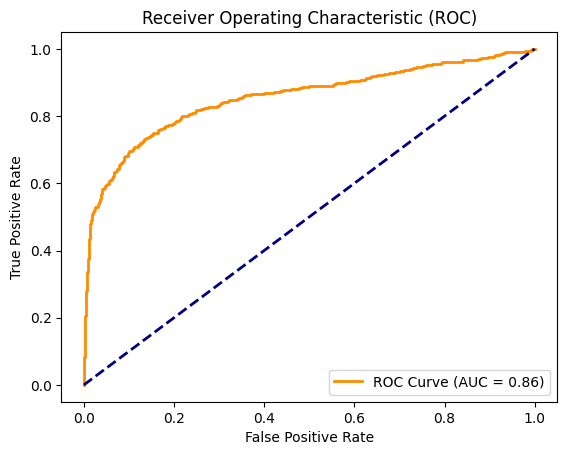

In [201]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

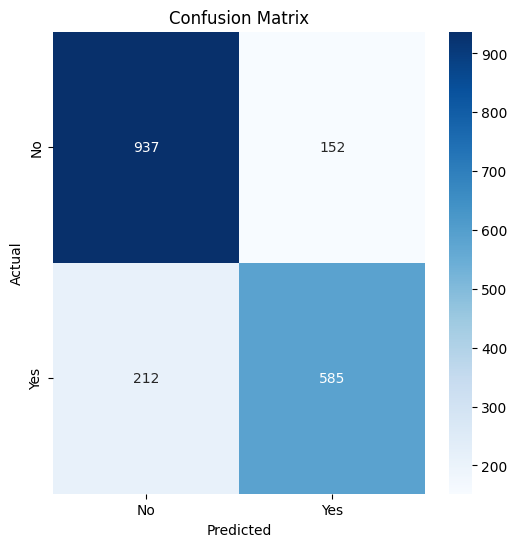

In [203]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [204]:
feature_names_new = features_new.columns.tolist()
print(feature_names_new)

['gunning_fog', 'smog_index', 'perplexity']


ExactExplainer explainer: 5656it [00:21, 142.51it/s]                          


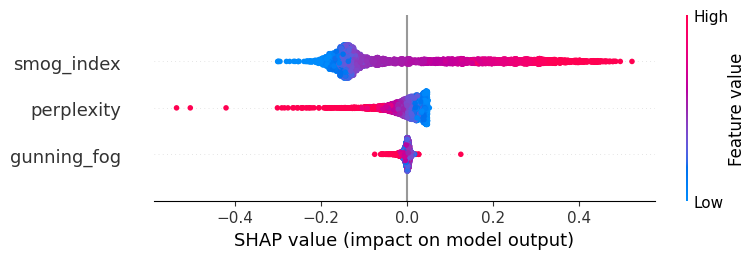

In [205]:
# Plotting the feature importance using SHAP
import shap
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# Plot summary
shap.summary_plot(shap_values, X_train, feature_names=feature_names_new)

In [206]:
features_test_h_new = df_htest_mod.drop(columns=[ 'text', 'generated', 'word_count', 'noun_count', 'verb_count', 'adverb_count','vocabulary_richness', 'polarity', 'subjectivity', 'noun_density','adjective_density', 'adverb_density', 'verb_density'])

In [207]:
features_test_h_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gunning_fog  15000 non-null  float64
 1   smog_index   15000 non-null  float64
 2   perplexity   15000 non-null  float64
dtypes: float64(3)
memory usage: 351.7 KB


In [208]:
# Test data from the huggingface dataset
X_test_h = features_test_h_new
y_test_h = df_htest_mod['generated']
y.astype(int)  
X_test_h = np.array(X_test_h, dtype=np.float32)  
y_test_h = np.array(y_test_h, dtype=np.float32)

In [209]:
X_test_h = scaler.fit_transform(X_test_h)

In [210]:
# Predicting on the huggingface test data
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve
y_pred = (best_model.predict(X_test_h) > 0.5).astype(int)  
y_prob = best_model.predict(X_test_h).ravel() 
fpr, tpr, thresholds = roc_curve(y_test_h, y_prob)
print(fpr)
roc_auc = auc(fpr, tpr)
balanced_accuracy = 0.5 * (tpr.mean() + (1 - fpr).mean())

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
[0.00000000e+00 4.00000000e-04 6.66666667e-04 ... 9.99466667e-01
 9.99733333e-01 1.00000000e+00]


In [211]:
print(f"ROC AUC: {roc_auc}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"True Positive Rate: {tpr.mean()}")
print(f"False Positive Rate: {fpr.mean()}")
print(f"Thresholds: {thresholds}")

ROC AUC: 0.9382398755555557
Balanced Accuracy: 0.7989406150061502
True Positive Rate: 0.7899553751537517
False Positive Rate: 0.1920741451414514
Thresholds: [       inf 0.9633413  0.9582241  ... 0.05433926 0.03482573 0.00565323]


In [212]:
# Predicting the accuracy, precision, recall, auc for the test data
loss, accuracy, precision, recall, auc = best_model.evaluate(X_test_h, y_test_h)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

  1/469 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8438 - auc_3: 0.9737 - loss: 0.4677 - precision_3: 0.9375 - recall_3: 0.7895

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.8548 - auc_3: 0.9398 - loss: 0.4650 - precision_3: 0.8928 - recall_3: 0.8057
Test Loss: 0.4658958911895752
Test Accuracy: 0.8546666502952576
Test Precision: 0.8931421637535095
Test Recall: 0.805733323097229
Test AUC: 0.9382473230361938


In [3]:
# Calculating the F1 score
f1_score = 2 * (0.8931 * 0.8057) / (0.8931 + 0.8057)
print(f"F1 Score: {f1_score}")

F1 Score: 0.8471517188603721


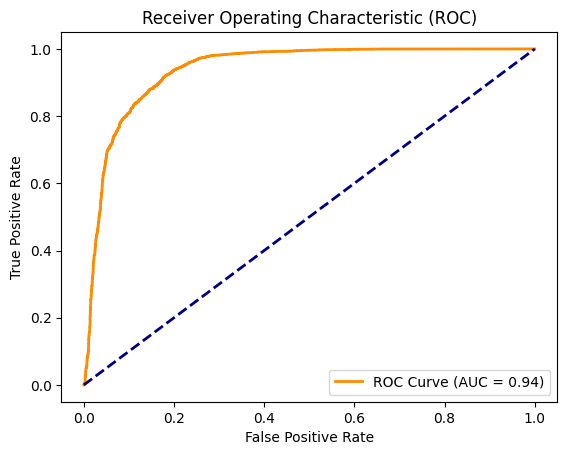

In [213]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

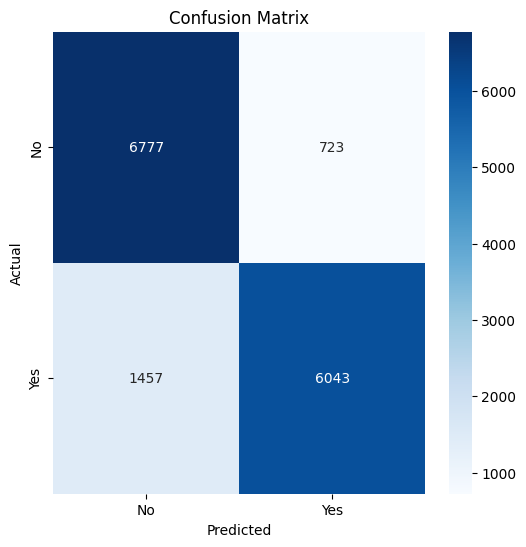

In [214]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test_h, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()